In [1]:
import os
import json
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import datetime
from copy import deepcopy

# Set Patameters

In [2]:
input_path = './data'
output_path_images = '.'



### Define functions

In [3]:

def get_diff(end, init):
    ''' Get change between values'''
    return (end - init) / init


def get_post_pip22_metrics(TEST_CHAIN, provider_block_info_df, chain_block_info_df, chain_cp_info_df, qos_info_df, verbose=True, QoS_s_limit=0.3, weeks_avg=1):
    '''
        Calculates the metris prior and post PIP-22 for a given chain

        Parameters:
            TEST_CHAIN (string) : Code of the chain to test.
            provider_block_info_df (pd.DataFrame) : Provider information from Pocket blockchain data.
            chain_block_info_df (pd.DataFrame) : Served blockchains information from Pocket blockchain data.
            chain_cp_info_df (pd.DataFrame) : Served blockchains information from Cherry Picker data.
            qos_info_df (pd.DataFrame) : Provider QoS information from Cherry Picker data.
            verbose (bool) : If true more info is shown during execution.
            QoS_s_limit (float) : Value of limit QoS in seconds.
            weeks_avg (float) : Number of weeks to average for initial and final mean valeus calculation.
        Returns:
            comp_info_df (pd.DataFrame) : Per provider metrics regarding the changes suffered prior and post PIP-22.
            disp_df (pd.DataFrame) : Per provider evolution of sessions and relays proportion by node.
    '''


    # Get list of providers
    providers_list = provider_block_info_df['provider'].unique()
    # GEt list of chains
    gateways_list = chain_cp_info_df['gateway'].unique()
    
    # Declare variables for outputs
    providers_metrics = list()
    disp_df = []

    if verbose:
        # Create figure
        plt.figure(dpi=150)
        ax = plt.gca()

    # Get data for this chain
    this_chain_block_df = chain_block_info_df.loc[chain_block_info_df['chain'] == TEST_CHAIN].sort_values(by='date', ascending=True).reset_index(drop=True)
    this_chain_cp_df = chain_cp_info_df.loc[chain_cp_info_df['chain'] == TEST_CHAIN].sort_values(by='date', ascending=True).reset_index(drop=True)

    # Analyze each provider alone
    for provider in providers_list:

        # Get data of this provider in this chain
        this_provider_block_df = provider_block_info_df.loc[(provider_block_info_df['provider'] == provider) *\
                                                       (provider_block_info_df['chain'] == TEST_CHAIN)].sort_values(by='date', ascending=True).reset_index(drop=True)
        # Get QoS of this provider in this chain
        w_avg_QoS = qos_info_df.loc[(qos_info_df['chain'] == TEST_CHAIN) *\
                                     qos_info_df['provider'] == provider]['avg_qos']
        # If no info, ignore provider
        if len(w_avg_QoS) == 0:
            continue
        w_avg_QoS = w_avg_QoS.values[0]

        # Get info
        info_list = list()

        # Set provider tier
        runner_quality = 'B' if w_avg_QoS > QoS_s_limit else 'A'

        # Remove chains and providers with low node count
        if any(this_provider_block_df['nodes_staked'].values.astype(np.float32) < 100):
            continue
        if any(this_chain_block_df['nodes'].values.astype(np.float32) < 100):
            continue

        # Get features for this provider:
        #   - Sessions by node
        #   - Providers node proportion of total nodes in the network
        #   - Proportion of total relays served by each node
        info_df = pd.DataFrame([(this_provider_block_df['total_sessions'].values.astype(np.float32)/this_provider_block_df['nodes_staked'].values.astype(np.float32)),
                                (this_provider_block_df['nodes_staked'].values.astype(np.float32)/this_chain_block_df['nodes'].values.astype(np.float32)),
                                (this_provider_block_df['total_relays'].values.astype(np.float32)/(this_chain_block_df['relays'].values.astype(np.float32)*this_provider_block_df['nodes_staked'].values.astype(np.float32)))],
                                )
        info_df = info_df.T
        info_df.columns=['provider_sessions_by_node','provider_network_nodes_share','provider_network_relays_by_node']
        # Add date field
        info_df['date'] = this_provider_block_df['date']
        info_df = info_df.sort_values(by='date', ascending=True)
        info_df = info_df.dropna()

        # Keep track of features by data
        aux_df = deepcopy(info_df[['provider_sessions_by_node','provider_network_relays_by_node']])
        aux_df['QoS'] = runner_quality
        aux_df['provider'] = provider
        aux_df['date'] = this_provider_block_df['date']
        aux_df['RT'] = w_avg_QoS # Response time
        aux_df['chain'] = TEST_CHAIN
        if len(disp_df) == 0:
            disp_df = deepcopy(aux_df)
        else:
            disp_df = pd.concat([disp_df, aux_df], axis=0)

        # Get initial and end averages
        avg_num = 7*weeks_avg 
        # for relays
        relay_change = get_diff(info_df['provider_network_relays_by_node'].tail(avg_num).mean(),
                info_df['provider_network_relays_by_node'].head(avg_num).mean())
        # and for sessions
        session_change = get_diff(info_df['provider_sessions_by_node'].tail(avg_num).mean(),
                info_df['provider_sessions_by_node'].head(avg_num).mean())
        # Calculate the correlation coeficient between the number of sessions by node and the relays proportion
        # along each of the days that were tracked
        corr_coef = np.corrcoef(info_df['provider_sessions_by_node'], info_df['provider_network_relays_by_node'])[0,1]

        if relay_change > 10:
            # outlyer for sure
            continue

        if verbose:
            # Plot scatter plot for this provider
            info_df.plot(x='provider_sessions_by_node', 
                         y=['provider_network_relays_by_node'], 
                         ax=ax, 
                         style='.', 
                         )


        # Save data in output var
        providers_metrics.append([
            provider,
            runner_quality,
            w_avg_QoS,
            relay_change, 
            session_change,
            corr_coef,
        ])
       
    # Convert to dataframe
    comp_info_df = pd.DataFrame(providers_metrics, columns = ['domain', 'type', 'QoS', 'relay_change', 'session_change', 'corr_coef'])
    comp_info_df['relay_to_session_change'] = comp_info_df['relay_change']/comp_info_df['session_change']
    comp_info_df['determination'] = (comp_info_df['corr_coef']**2)

    if verbose:
        # Add correct legends and show
        plt.legend(providers_list, loc="upper left", bbox_to_anchor=(1,1))
        plt.grid()
        plt.show()
    
    return comp_info_df, disp_df

### Load all data

In [4]:
chain_cp_info_df = pd.read_csv(os.path.join(input_path, 'chain_cp_info.csv'), index_col=0)
chain_cp_info_df['date'] = chain_cp_info_df['date'].map(lambda x : datetime.datetime.strptime(x, "%Y-%m-%d"))
chain_cp_info_df

,date,gateway,chain,relays,relays_norm
0,2022-06-28,ap-east-1,0009,30497085,0.116172
75,2022-06-28,us-east-1,0027,730491,0.006899
74,2022-06-28,eu-west-3,0027,904161,0.008539
73,2022-06-28,eu-west-2,0027,487943,0.004608
72,2022-06-28,eu-west-1,0027,16560,0.000156
...,...,...,...,...,...
7100,2022-09-12,ap-southeast-1,0004,6421529,0.067927
7099,2022-09-12,ap-northeast-2,0004,2198092,0.023251
7098,2022-09-12,ap-east-1,0004,2233380,0.023625
7122,2022-09-12,us-east-2,0049,1991220,0.070866


In [5]:
chain_block_info_df = pd.read_csv(os.path.join(input_path, 'chain_block_info.csv'), index_col=0)
chain_block_info_df['date'] = chain_block_info_df['date'].map(lambda x : datetime.datetime.strptime(x, "%Y-%m-%d"))
chain_block_info_df

,date,chain,relays,nodes
0,2022-06-28,0009,262516561,14542
1,2022-06-28,0040,272949539,13912
2,2022-06-28,0004,55065862,4075
3,2022-06-28,0049,45253518,6818
4,2022-06-28,0021,70933143,12208
...,...,...,...,...
546,2022-09-12,0004,94535757,2888
547,2022-09-12,0049,28098277,7114
548,2022-09-12,0021,75563770,11362
549,2022-09-12,0027,89239518,12729


In [6]:
provider_block_info_df = pd.read_csv(os.path.join(input_path, 'provider_block_info.csv'), index_col=0)
provider_block_info_df['date'] = provider_block_info_df['date'].map(lambda x : datetime.datetime.strptime(x, "%Y-%m-%d"))
provider_block_info_df

,date,chain,provider,total_relays,nodes_staked,total_sessions
0,2022-06-28,0009,P1,1886076,145,79
75,2022-06-28,0027,P9,170070,628,109
74,2022-06-28,0027,P8,748042,1006,420
73,2022-06-28,0027,P5,19092448,7694,3007
72,2022-06-28,0027,P4,8060681,2845,1430
...,...,...,...,...,...,...
7100,2022-09-12,0004,P6,9645226,1953,245
7099,2022-09-12,0004,P2,5268392,951,131
7098,2022-09-12,0004,P1,913755,174,22
7122,2022-09-12,0049,P10,125150,127,41


In [7]:
qos_info_df = pd.read_csv(os.path.join(input_path, 'qos_info.csv'), index_col=0)
qos_info_df

,provider,chain,avg_qos
0,P1,0009,0.231478
1,P9,0009,0.392215
2,P8,0009,0.366632
3,P5,0009,0.426213
4,P4,0009,0.240915
...,...,...,...
96,P7,03DF,0.219410
97,P6,03DF,0.215471
98,P2,03DF,0.197559
99,P10,03DF,0.308382


# Analyze and Plot

In [8]:
# get tested chains
chains_test = chain_block_info_df['chain'].unique()

# Get network variation coeficient for each chain
network_variation_coef = list()
network_relays = list()
for chain in chains_test:
    this_val = chain_block_info_df.loc[chain_block_info_df['chain']==chain]['relays']
    network_relays.append(this_val.mean())
    network_variation_coef.append(this_val.std()/this_val.mean())


# Get mean local variation coeficient for each chain
local_variation_coef = list()
for chain in chains_test:
    aux_df = deepcopy(chain_cp_info_df.loc[chain_cp_info_df['chain'] == chain])

    aux_df['mean_relays'] = aux_df['relays']
    aux_df['std_relays'] = aux_df['relays']
    # Coeficient of variation / relative standard deviation
    aux_df = aux_df.groupby(['gateway']).agg({"mean_relays": "mean", "std_relays": "std"}).reset_index()
    aux_df['rel_std_relays'] = aux_df['std_relays']/aux_df['mean_relays']


    local_variation_coef.append((aux_df['rel_std_relays']*aux_df['mean_relays']).sum()/aux_df['mean_relays'].sum())


variation_info = list()
for chain, relays, net, local in zip(chains_test, network_relays, network_variation_coef, local_variation_coef):
    variation_info.append([chain, relays, net, local])
variation_info_df = pd.DataFrame(variation_info, columns=['chain', 'relays', 'network', 'local'])

In [9]:
variation_info_df.sort_values('network', ascending=True)

,chain,relays,network,local
0,0009,2.301783e+08,0.095861,0.322269
3,0049,3.162574e+07,0.175481,0.391505
5,0027,9.885764e+07,0.222863,0.512637
1,0040,2.121117e+08,0.321664,0.475414
7,0005,3.445853e+07,0.365582,0.569260
2,0004,7.783554e+07,0.478167,0.869143
4,0021,1.347896e+08,0.559821,1.103505
6,03DF,3.017867e+07,0.577004,0.674622


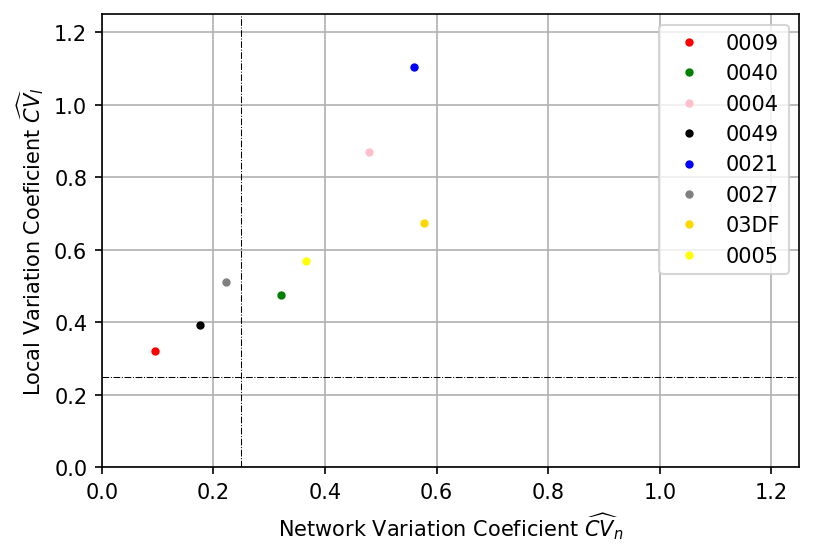

In [10]:
# Show local variation vs network variation plot for each of the chains under study

chains_colors = ['red', 'green', 'pink', 'black', 'blue', 'grey', 'gold', 'yellow']


plt.figure(dpi=150)
for val, std, col, chain in zip(network_variation_coef, local_variation_coef, chains_colors, chains_test):
    plt.plot(val, std, '.', color = col)

plt.hlines(y=0.25, xmin=0,xmax=1.25, color='black', linestyles='-.', linewidth=0.5)
plt.vlines(x=0.25, ymin=0,ymax=1.25, color='black', linestyles='-.', linewidth=0.5)

plt.grid()
plt.legend(chains_test)
plt.xlabel('Network Variation Coeficient '+r'$\widehat{CV}_n$')
plt.ylabel('Local Variation Coeficient '+r'$\widehat{CV}_l$')
plt.xlim([0,1.25])
plt.ylim([0,1.25])
plt.show()

### Single chain plots

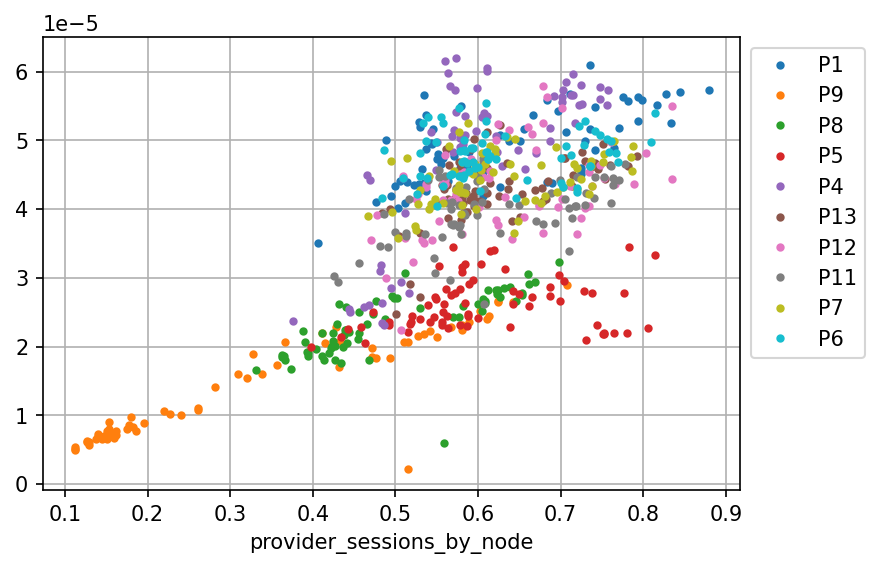

,domain,type,QoS,relay_change,session_change,corr_coef,relay_to_session_change,determination
0,P1,A,0.231478,0.077560,0.417404,0.650921,0.185815,0.423698
1,P9,B,0.392215,1.796445,2.595372,0.927576,0.692173,0.860397
2,P8,B,0.366632,0.159631,0.398243,0.728160,0.400837,0.530217
3,P5,B,0.426213,-0.013277,0.381674,0.225651,-0.034785,0.050918
4,P4,A,0.240915,0.886861,0.471123,0.747496,1.882441,0.558750
5,P12,A,0.258519,0.113985,0.276027,0.537621,0.412948,0.289036
6,P11,A,0.239448,0.184564,0.353260,0.446764,0.522459,0.199598
7,P6,A,0.238606,0.253175,0.390684,0.498018,0.648030,0.248022
8,P2,A,0.195307,-0.033356,0.273713,0.356026,-0.121865,0.126755
9,P14,A,0.242639,-0.026111,0.339322,0.168718,-0.076951,0.028466


In [175]:
#['0009', '0040', '0004', '0049', '0021', '0027', '0005', '03DF']
TEST_CHAIN = '0009'
QOS_LIMIT = 0.3
WEEKS_AVG = 2

comp_info_df, disp_df = get_post_pip22_metrics(TEST_CHAIN, 
                                               provider_block_info_df, 
                                               chain_block_info_df, 
                                               chain_cp_info_df, 
                                               qos_info_df,
                                               QoS_s_limit=QOS_LIMIT, 
                                               weeks_avg=WEEKS_AVG)
comp_info_df

#### Sessions by node evolution

Initial mean: 0.492937
Final mean: 0.711265
Mean variation: 0.44


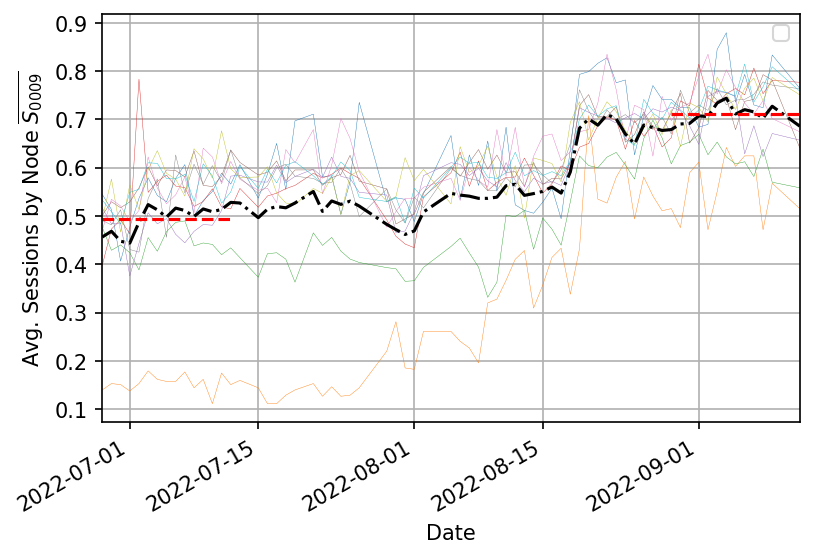

In [176]:


plt.figure(dpi=150)
ax = plt.gca()
provider_list = list(disp_df['provider'].unique())
for provider in provider_list:
    disp_df.loc[disp_df['provider']==provider].plot(x='date', y='provider_sessions_by_node', ax=ax, linewidth=0.2)

disp_df_aux = deepcopy(disp_df)
disp_df_aux = disp_df_aux.groupby('date').agg({"provider_sessions_by_node":"mean"})
disp_df_aux.plot(y='provider_sessions_by_node', ax=ax, color='black', linestyle='-.')


date_ini_1 = datetime.datetime.strptime('2022-06-28', "%Y-%m-%d")
date_ini_2 = date_ini_1+datetime.timedelta(days=7*WEEKS_AVG)
mean_ini = disp_df_aux[disp_df_aux.index < date_ini_2].mean().values
print('Initial mean: %g'% mean_ini)
date_fin_2 = datetime.datetime.strptime('2022-09-12', "%Y-%m-%d")
date_fin_1 = date_fin_2-datetime.timedelta(days=7*WEEKS_AVG)
mean_fin = disp_df_aux[disp_df_aux.index > date_fin_1].mean().values
print('Final mean: %g'% mean_fin)
print('Mean variation: %0.2f'% ((mean_fin-mean_ini)/mean_ini))

plt.hlines(y=mean_ini, xmin=date_ini_1, xmax=date_ini_2, color='red', linestyle='--')
plt.hlines(y=mean_fin, xmin=date_fin_1, xmax=date_fin_2, color='red', linestyle='--')
# plt.legend(provider_list)
plt.legend([])
plt.grid()
plt.xlim(date_ini_1, date_fin_2)
plt.xlabel('Date')
plt.ylabel('Avg. Sessions by Node '+r'$\overline{S_{%s}}$'%TEST_CHAIN)

plt.draw()
plt.savefig(os.path.join(output_path_images, 'evol_sessions_node_'+TEST_CHAIN+'.png'))

plt.show()




#### Relay proportion by node evolution

Initial mean: 3.34021e-05
Final mean: 3.95621e-05
Mean variation: 0.18


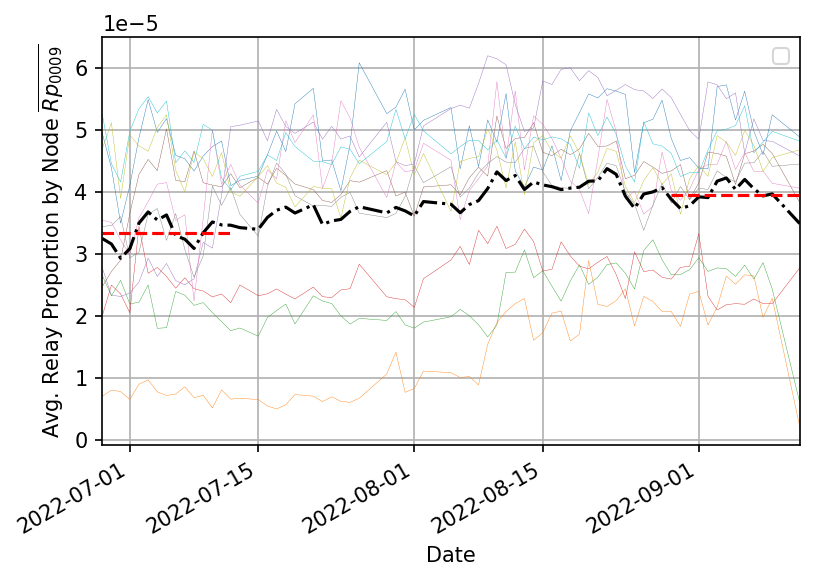

In [177]:


plt.figure(dpi=150)
ax = plt.gca()
provider_list = list(disp_df['provider'].unique())
for provider in provider_list:
    disp_df.loc[disp_df['provider']==provider].plot(x='date', y='provider_network_relays_by_node', ax=ax, linewidth=0.2)

disp_df_aux = deepcopy(disp_df)
disp_df_aux = disp_df_aux.groupby('date').agg({"provider_network_relays_by_node":"mean"})
disp_df_aux.plot(y='provider_network_relays_by_node', ax=ax, color='black', linestyle='-.')


date_ini_1 = datetime.datetime.strptime('2022-06-28', "%Y-%m-%d")
date_ini_2 = date_ini_1+datetime.timedelta(days=7*WEEKS_AVG)
mean_ini = disp_df_aux[disp_df_aux.index < date_ini_2].mean().values
print('Initial mean: %g'% mean_ini)
date_fin_2 = datetime.datetime.strptime('2022-09-12', "%Y-%m-%d")
date_fin_1 = date_fin_2-datetime.timedelta(days=7*WEEKS_AVG)
mean_fin = disp_df_aux[disp_df_aux.index > date_fin_1].mean().values
print('Final mean: %g'% mean_fin)
print('Mean variation: %0.2f'% ((mean_fin-mean_ini)/mean_ini))
plt.hlines(y=mean_ini, xmin=date_ini_1, xmax=date_ini_2, color='red', linestyle='--')
plt.hlines(y=mean_fin, xmin=date_fin_1, xmax=date_fin_2, color='red', linestyle='--')
# plt.legend(provider_list)
plt.legend([])
plt.grid()
plt.xlim(date_ini_1, date_fin_2)
plt.xlabel('Date')
plt.ylabel('Avg. Relay Proportion by Node '+r'$\overline{Rp_{%s}}$'%TEST_CHAIN)

plt.draw()
plt.savefig(os.path.join(output_path_images, 'evol_relays_prop_node_'+TEST_CHAIN+'.png'))


plt.show()


#### Determination coeficient values

In [178]:
tier_A_det_mean = comp_info_df.loc[comp_info_df['type'] == 'A']['determination'].mean()
tier_A_det_std = comp_info_df.loc[comp_info_df['type'] == 'A']['determination'].std()
tier_B_det_mean = comp_info_df.loc[comp_info_df['type'] == 'B']['determination'].mean()
tier_B_det_std = comp_info_df.loc[comp_info_df['type'] == 'B']['determination'].std()

print('Tier A:\n\tDet.: %0.2f +/- %0.2f' % (tier_A_det_mean, tier_A_det_std))
print('Tier B:\n\tDet.: %0.2f +/- %0.2f' % (tier_B_det_mean, tier_B_det_std))

Tier A:
	Det.: 0.27 +/- 0.18
Tier B:
	Det.: 0.48 +/- 0.41


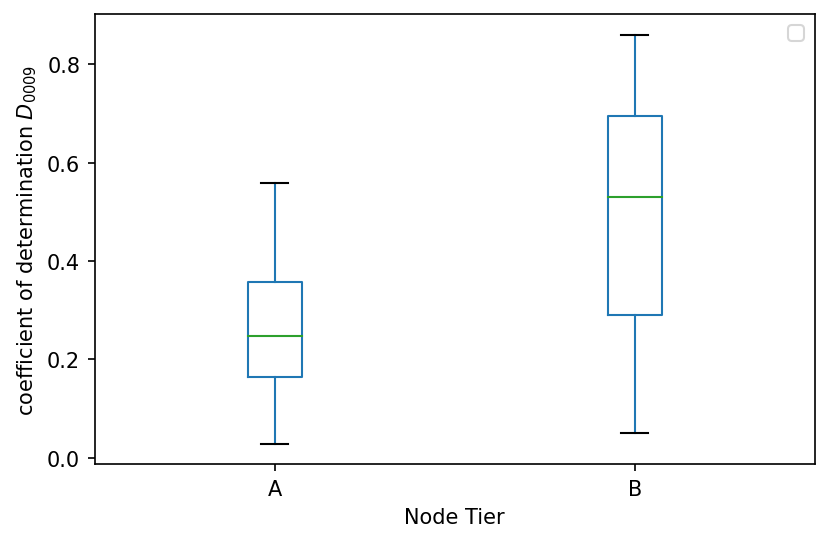

In [179]:

plt.figure(dpi=150)
ax = plt.gca()
comp_info_df.boxplot(by='type', column=['determination'], ax=ax, showfliers=False)
ax.get_figure().suptitle("")
plt.legend([])
plt.grid()
plt.xlabel('Node Tier')
plt.ylabel('coefficient of determination '+r'$D_{%s}$'%TEST_CHAIN)
plt.title('')

plt.draw()
plt.savefig(os.path.join(output_path_images, 'coef_det_QoS_boxplot_'+TEST_CHAIN+'.png'))

plt.show()


#### Scatter plots by QoS

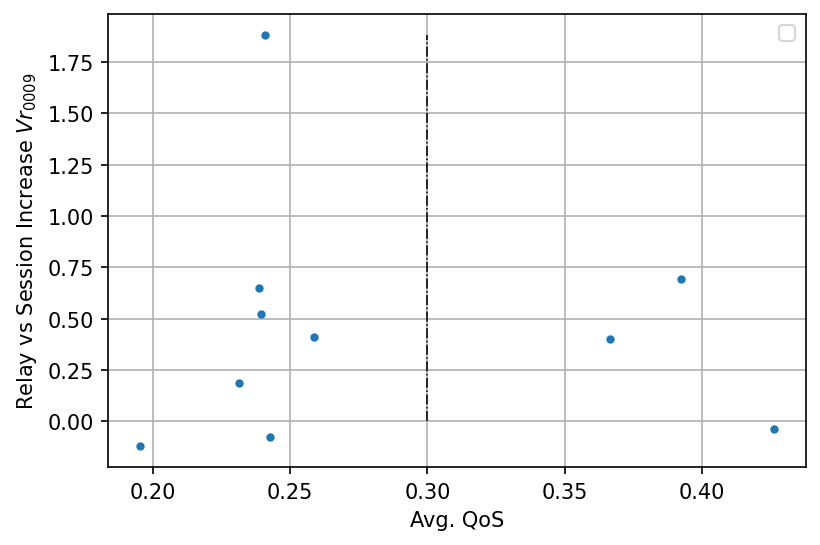

In [180]:
plt.figure(dpi=150)
ax = plt.gca()
comp_info_df.plot(x='QoS', y=['relay_to_session_change'], ax=ax, style='.')
plt.vlines(x=QOS_LIMIT, ymin=0, ymax=comp_info_df['relay_to_session_change'].max(), colors='black', linestyles='-.', linewidth=0.75)
plt.legend([])
plt.grid()
plt.xlabel('Avg. QoS')
plt.ylabel('Relay vs Session Increase '+r'$Vr_{%s}$'%TEST_CHAIN)

plt.draw()
plt.savefig(os.path.join(output_path_images, 'relays_to_session_var_'+TEST_CHAIN+'.png'))


plt.show()

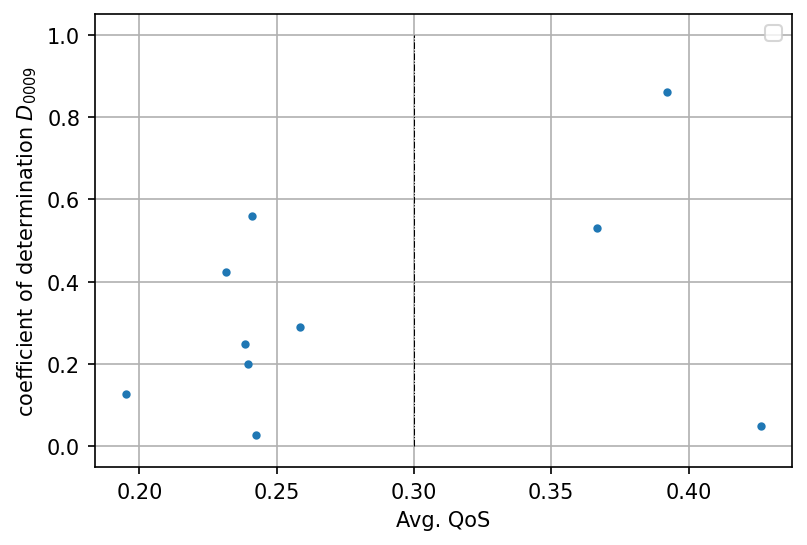

In [181]:
plt.figure(dpi=150)
ax = plt.gca()
comp_info_df.plot(x='QoS', y=['determination'], ax=ax, style='.')
plt.vlines(x=QOS_LIMIT, ymin=0, ymax=1., colors='black', linestyles='-.', linewidth=0.5)
plt.legend([])
plt.grid()
plt.xlabel('Avg. QoS')
plt.ylabel('coefficient of determination '+r'$D_{%s}$'%TEST_CHAIN)


plt.draw()
plt.savefig(os.path.join(output_path_images, 'coef_det_QoS_'+TEST_CHAIN+'.png'))

plt.show()

## Whole Network Plots

Handle with care..

In [182]:
chains_test = ['0009', '0040', '0004', '0049', '0021', '0027', '0005'] #, '03DF']


comp_info_df_network = []
scatter_df_network = []
for chain in chains_test:
    print(chain)
    aux_df, aux_df2 = get_post_pip22_metrics(chain, 
                                            provider_block_info_df, 
                                               chain_block_info_df, 
                                               chain_cp_info_df, 
                                               qos_info_df,
                                               QoS_s_limit=QOS_LIMIT, 
                                               weeks_avg=WEEKS_AVG,
                                               verbose=False)

    if len(comp_info_df_network) == 0:
        comp_info_df_network = deepcopy(aux_df)
        scatter_df_network = deepcopy(aux_df2)
    else:
        comp_info_df_network = pd.concat([comp_info_df_network, aux_df], axis=0)
        scatter_df_network = pd.concat([scatter_df_network, aux_df2], axis=0)

0009
0040
0004
0049
0021
0027
0005


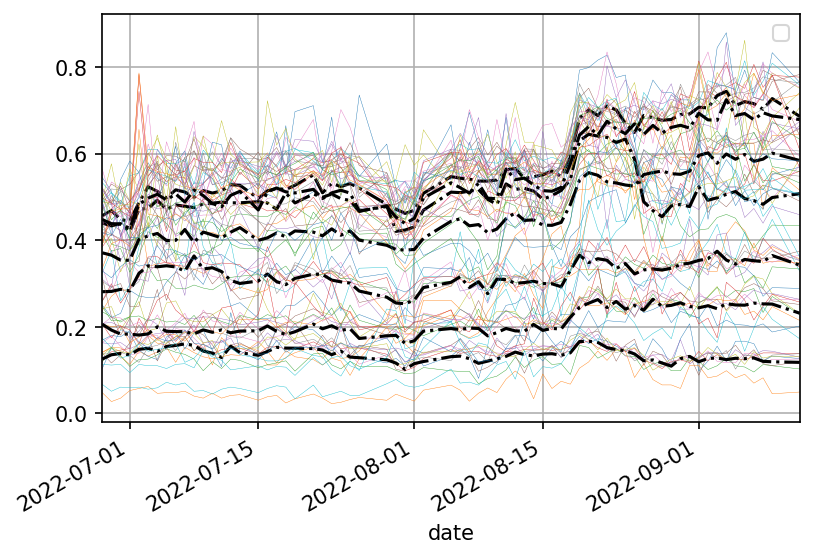

In [183]:



plt.figure(dpi=150)
ax = plt.gca()

chain_list = list(scatter_df_network['chain'].unique())

for chain in chain_list: 
    scatter_df_use = scatter_df_network.loc[scatter_df_network['chain']==chain]
    provider_list = list(scatter_df_use['provider'].unique())
    for provider in provider_list:
        scatter_df_use.loc[scatter_df_use['provider']==provider].plot(x='date', y='provider_sessions_by_node', ax=ax, linewidth=0.2)

    disp_df_aux = deepcopy(scatter_df_use)
    disp_df_aux = disp_df_aux.groupby('date').agg({"provider_sessions_by_node":"mean"})
    disp_df_aux.plot(y='provider_sessions_by_node', ax=ax, color='black', linestyle='-.')


    date_ini_1 = datetime.datetime.strptime('2022-06-28', "%Y-%m-%d")
    date_ini_2 = datetime.datetime.strptime('2022-07-08', "%Y-%m-%d")
    mean_ini = disp_df_aux[disp_df_aux.index < date_ini_2].mean().values
    date_fin_1 = datetime.datetime.strptime('2022-09-02', "%Y-%m-%d")
    date_fin_2 = datetime.datetime.strptime('2022-09-12', "%Y-%m-%d")
    mean_fin = disp_df_aux[disp_df_aux.index > date_fin_1].mean().values

plt.legend([])
plt.grid()
plt.xlim(date_ini_1, date_fin_2)
plt.show()


Initial mean: 0.361581
Final mean: 0.467541
Mean variation: 0.29


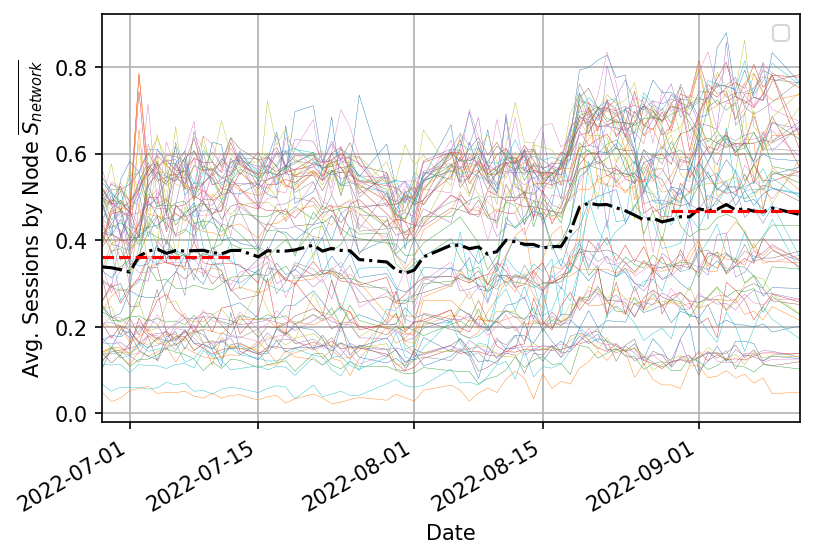

In [184]:


plt.figure(dpi=150)
ax = plt.gca()

chain_list = list(scatter_df_network['chain'].unique())

for chain in chain_list: 
    scatter_df_use = scatter_df_network.loc[scatter_df_network['chain']==chain]
    provider_list = list(scatter_df_use['provider'].unique())
    for provider in provider_list:
        scatter_df_use.loc[scatter_df_use['provider']==provider].plot(x='date', y='provider_sessions_by_node', ax=ax, linewidth=0.2)

disp_df_aux = deepcopy(scatter_df_network)
disp_df_aux = disp_df_aux.groupby('date').agg({"provider_sessions_by_node":"mean"})
disp_df_aux.plot(y='provider_sessions_by_node', ax=ax, color='black', linestyle='-.')


date_ini_1 = datetime.datetime.strptime('2022-06-28', "%Y-%m-%d")
date_ini_2 = date_ini_1+datetime.timedelta(days=7*WEEKS_AVG)
mean_ini = disp_df_aux[disp_df_aux.index < date_ini_2].mean().values
print('Initial mean: %g'%mean_ini)
date_fin_2 = datetime.datetime.strptime('2022-09-12', "%Y-%m-%d")
date_fin_1 = date_fin_2-datetime.timedelta(days=7*WEEKS_AVG)
mean_fin = disp_df_aux[disp_df_aux.index > date_fin_1].mean().values
print('Final mean: %g'% mean_fin)
print('Mean variation: %0.2f'% ((mean_fin-mean_ini)/mean_ini))

plt.hlines(y=mean_ini, xmin=date_ini_1, xmax=date_ini_2, color='red', linestyle='--')
plt.hlines(y=mean_fin, xmin=date_fin_1, xmax=date_fin_2, color='red', linestyle='--')
# plt.legend(provider_list)
plt.legend([])
plt.grid()
plt.xlim(date_ini_1, date_fin_2)
plt.xlabel('Date')
plt.ylabel('Avg. Sessions by Node '+r'$\overline{S_{network}}$')

plt.draw()
plt.savefig(os.path.join(output_path_images, 'evol_sessions_node_network.png'))

plt.show()




Initial mean: 3.34021e-05
Final mean: 3.95621e-05
Mean variation: 0.18


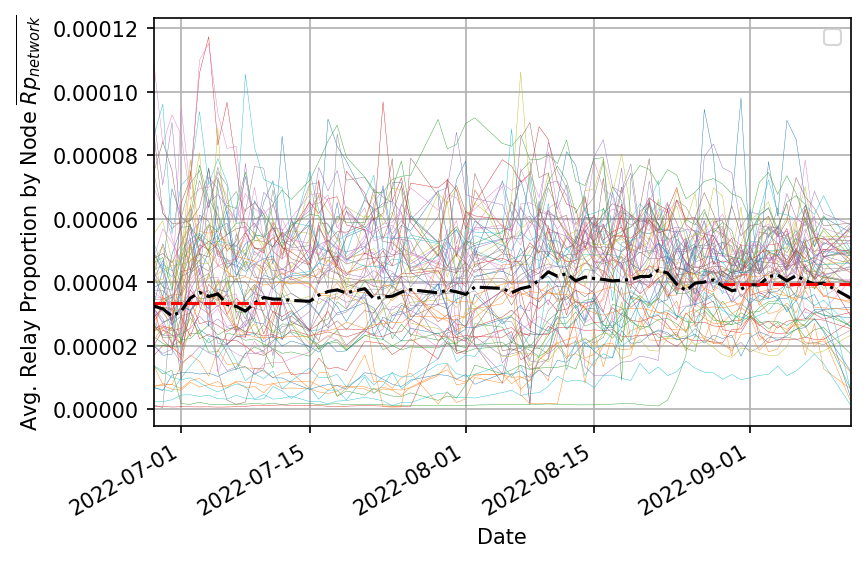

In [185]:


plt.figure(dpi=150)
ax = plt.gca()

chain_list = list(scatter_df_network['chain'].unique())

for chain in chain_list: 
    scatter_df_use = scatter_df_network.loc[scatter_df_network['chain']==chain]
    provider_list = list(scatter_df_use['provider'].unique())
    for provider in provider_list:
        scatter_df_use.loc[scatter_df_use['provider']==provider].plot(x='date', y='provider_network_relays_by_node', ax=ax, linewidth=0.2)


disp_df_aux = deepcopy(disp_df)
disp_df_aux = disp_df_aux.groupby('date').agg({"provider_network_relays_by_node":"mean"})
disp_df_aux.plot(y='provider_network_relays_by_node', ax=ax, color='black', linestyle='-.')


date_ini_1 = datetime.datetime.strptime('2022-06-28', "%Y-%m-%d")
date_ini_2 = date_ini_1+datetime.timedelta(days=7*WEEKS_AVG)
mean_ini = disp_df_aux[disp_df_aux.index < date_ini_2].mean().values
print('Initial mean: %g'% mean_ini)
date_fin_2 = datetime.datetime.strptime('2022-09-12', "%Y-%m-%d")
date_fin_1 = date_fin_2-datetime.timedelta(days=7*WEEKS_AVG)
mean_fin = disp_df_aux[disp_df_aux.index > date_fin_1].mean().values
print('Final mean: %g'% mean_fin)
print('Mean variation: %0.2f'% ((mean_fin-mean_ini)/mean_ini))
plt.hlines(y=mean_ini, xmin=date_ini_1, xmax=date_ini_2, color='red', linestyle='--')
plt.hlines(y=mean_fin, xmin=date_fin_1, xmax=date_fin_2, color='red', linestyle='--')
# plt.legend(provider_list)
plt.legend([])
plt.grid()
plt.xlim(date_ini_1, date_fin_2)
plt.xlabel('Date')
plt.ylabel('Avg. Relay Proportion by Node '+r'$\overline{Rp_{network}}$')

plt.draw()
plt.savefig(os.path.join(output_path_images, 'evol_relays_prop_node_network.png'))


plt.show()


In [186]:
tier_A_det_mean_network = comp_info_df_network.loc[comp_info_df_network['type'] == 'A']['determination'].mean()
tier_A_det_std_network = comp_info_df_network.loc[comp_info_df_network['type'] == 'A']['determination'].std()
tier_B_det_mean_network = comp_info_df_network.loc[comp_info_df_network['type'] == 'B']['determination'].mean()
tier_B_det_std_network = comp_info_df_network.loc[comp_info_df_network['type'] == 'B']['determination'].std()

print('Tier A:\n\tDet.: %0.2f +/- %0.2f' % (tier_A_det_mean_network, tier_A_det_std_network))
print('Tier B:\n\tDet.: %0.2f +/- %0.2f' % (tier_B_det_mean_network, tier_B_det_std_network))

Tier A:
	Det.: 0.22 +/- 0.20
Tier B:
	Det.: 0.41 +/- 0.29


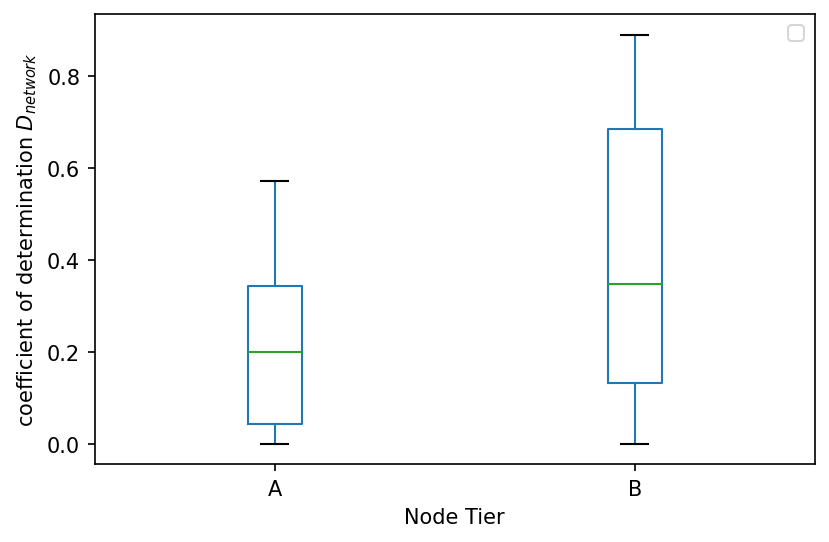

In [187]:

plt.figure(dpi=150)
ax = plt.gca()
comp_info_df_network.boxplot(by='type', column=['determination'], ax=ax, showfliers=False)
ax.get_figure().suptitle("")
plt.legend([])
plt.grid()
plt.xlabel('Node Tier')
plt.ylabel('coefficient of determination '+r'$D_{network}$')
plt.title('')

plt.draw()
plt.savefig(os.path.join(output_path_images, 'coef_det_QoS_boxplot_network.png'))

plt.show()
